In [60]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict


In [61]:
API_KEY = "ea2d0e0fa9e7cefdb2f33eb58abad178"
CITY = "Lahore"
URL = f"http://api.openweathermap.org/data/2.5/weather?q={CITY}&appid={API_KEY}&units=metric"


In [62]:
import requests
def fetch_weather_data():
    response = requests.get(URL)
    data = response.json()

    weather_info = {
        'temp': data['main']['temp'],
        'humidity': data['main']['humidity'],
        'pressure': data['main']['pressure'],
        'wind_speed': data['wind']['speed'],
        'cloudiness': data['clouds']['all'],
        'visibility': data.get('visibility', 10000),  # default if missing
        'condition': data['weather'][0]['main']
    }
    return weather_info

weather_data = fetch_weather_data()
print(weather_data)


{'temp': 30.99, 'humidity': 48, 'pressure': 1004, 'wind_speed': 0, 'cloudiness': 20, 'visibility': 4000, 'condition': 'Haze'}


In [63]:
def classify_observation(data):
    obs = {
        'temp': 'hot' if data['temp'] > 30 else 'mild' if data['temp'] > 20 else 'cold',
        'humidity': 'high' if data['humidity'] > 70 else 'medium' if data['humidity'] > 40 else 'low',
        'pressure': 'high' if data['pressure'] > 1015 else 'normal' if data['pressure'] > 1005 else 'low',
        'wind': 'windy' if data['wind_speed'] > 10 else 'breezy' if data['wind_speed'] > 5 else 'calm',
        'clouds': 'cloudy' if data['cloudiness'] > 50 else 'clear',
        'visibility': 'poor' if data['visibility'] < 5000 else 'good',
        'condition': data['condition'].lower()  # e.g., 'clear', 'rain', 'fog'
    }

    # Convert to a single label (you could also use tuples)
    return '_'.join(obs.values())

obs_label = classify_observation(weather_data)
print("Observation label:", obs_label)


Observation label: hot_medium_low_calm_clear_poor_haze


In [ ]:
import random

states = ['sunny', 'rainy', 'foggy']
observations = []

state_seq = []
observation_seq = []

for _ in range(100):
    state = random.choice(states)
    obs = classify_observation(fetch_weather_data())  
    state_seq.append(state)
    observation_seq.append(obs)


In [65]:
ob_occurrence_dic = {}

for i in range(len(state_seq)):
    state = state_seq[i]
    obs = observation_seq[i]

    if state not in ob_occurrence_dic:
        ob_occurrence_dic[state] = {obs: 1}
    else:
        if obs not in ob_occurrence_dic[state]:
            ob_occurrence_dic[state][obs] = 1
        else:
            ob_occurrence_dic[state][obs] += 1

# Normalize
emission_matrix = {}
for state, obs_counts in ob_occurrence_dic.items():
    total = sum(obs_counts.values())
    emission_matrix[state] = {obs: count / total for obs, count in obs_counts.items()}

emission_matrix


{'rainy': {'hot_medium_low_calm_clear_poor_haze': 1.0},
 'foggy': {'hot_medium_low_calm_clear_poor_haze': 1.0},
 'sunny': {'hot_medium_low_calm_clear_poor_haze': 1.0}}

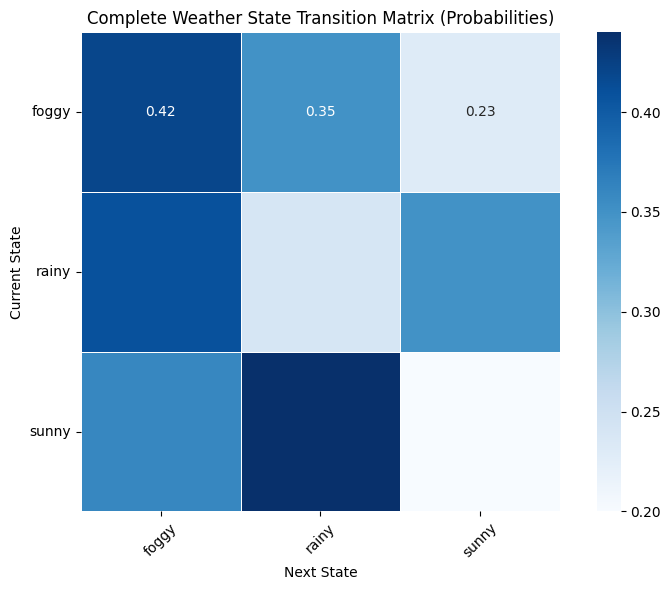

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Get all unique states from the sequence
all_states = sorted(list(set(state_seq)))

# Step 1: Count transitions
transition_counts = defaultdict(lambda: defaultdict(int))
for i in range(len(state_seq) - 1):
    curr_state = state_seq[i]
    next_state = state_seq[i + 1]
    transition_counts[curr_state][next_state] += 1

# Step 2: Normalize and ensure all states are present
transition_matrix = {}
for from_state in all_states:
    total = sum(transition_counts[from_state].values())
    transition_matrix[from_state] = {}
    for to_state in all_states:
        prob = transition_counts[from_state][to_state] / total if total > 0 else 0.0
        transition_matrix[from_state][to_state] = round(prob, 2)

# Step 3: Convert to full DataFrame
df_trans = pd.DataFrame.from_dict(transition_matrix, orient='index', columns=all_states)
df_trans = df_trans.fillna(0)  # In case some states were completely missing

# Step 4: Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_trans, annot=True, cmap="Blues", fmt=".2f", square=True, linewidths=.5)
plt.title("Complete Weather State Transition Matrix (Probabilities)")
plt.xlabel("Next State")
plt.ylabel("Current State")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [67]:
def predict_next_state(current_state):
    probs = transition_matrix.get(current_state, {})
    if not probs:
        return random.choice(states)
    return max(probs, key=probs.get)

# Predict from latest state
latest_state = state_seq[-1]
next_state = predict_next_state(latest_state)

print(f"Current State: {latest_state}")
print(f"Predicted Next State: {next_state}")


Current State: sunny
Predicted Next State: rainy


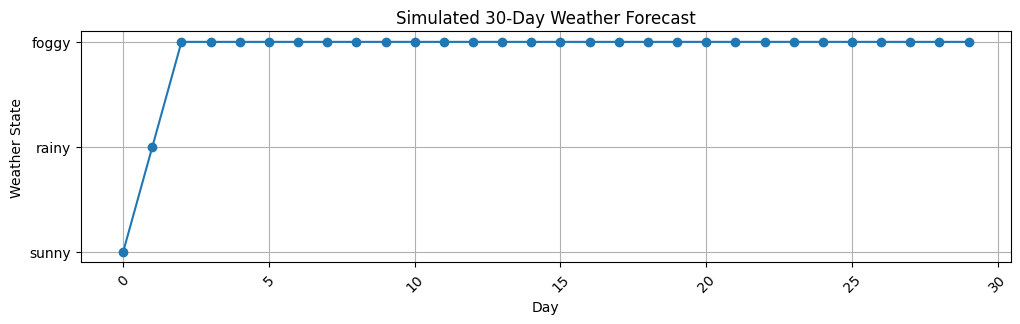

In [68]:
simulated_days = [latest_state]
for _ in range(29):
    next_state = predict_next_state(simulated_days[-1])
    simulated_days.append(next_state)

plt.figure(figsize=(12, 3))
plt.plot(simulated_days, marker='o', linestyle='-')
plt.title("Simulated 30-Day Weather Forecast")
plt.xlabel("Day")
plt.ylabel("Weather State")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


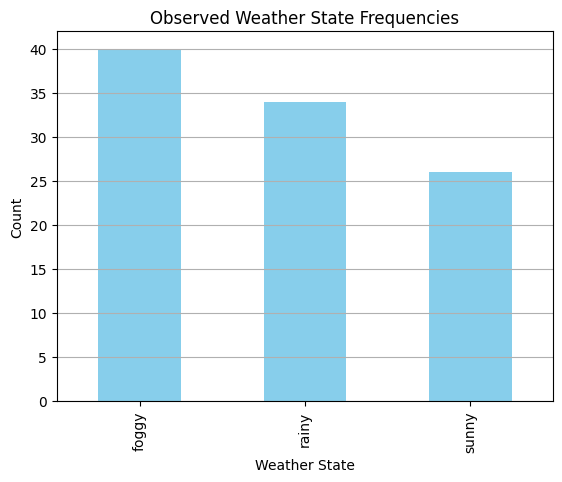

In [69]:
state_counts = pd.Series(state_seq).value_counts()
state_counts.plot(kind='bar', color='skyblue')
plt.title("Observed Weather State Frequencies")
plt.xlabel("Weather State")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()


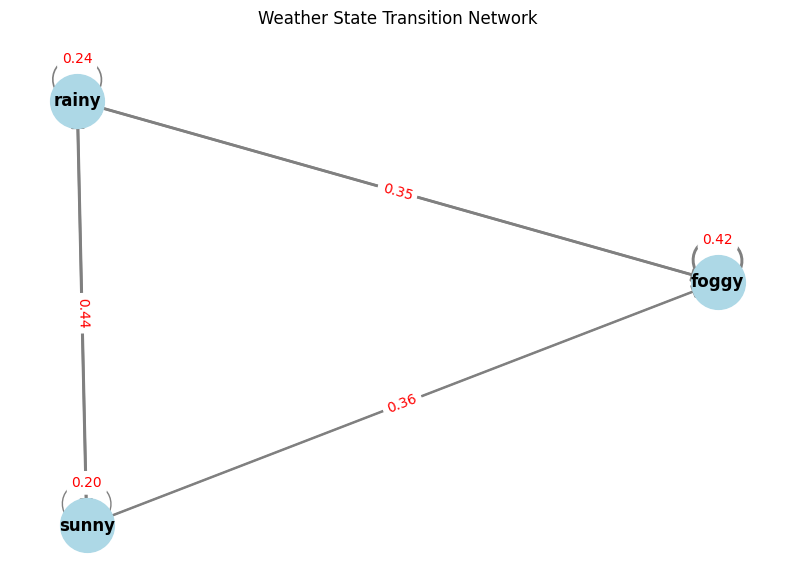

In [73]:
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Initialize a directed graph
G = nx.DiGraph()

# Step 2: Add edges with weights (probabilities from transition matrix)
for current_state, transitions in transition_matrix.items():
    for next_state, probability in transitions.items():
        if probability > 0:
            G.add_edge(current_state, next_state, weight=round(probability, 2))

# Step 3: Define layout
pos = nx.spring_layout(G, seed=42)

# Step 4: Draw nodes and edges with scaled widths
plt.figure(figsize=(10, 7))
edges = G.edges(data=True)
weights = [edge[2]['weight'] * 5 for edge in edges]  # scale for better visibility

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1500)
nx.draw_networkx_edges(G, pos, width=weights, edge_color='gray', arrows=True, arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Add edge labels (probabilities)
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

# Final touches
plt.title("Weather State Transition Network")
plt.axis('off')
plt.show()


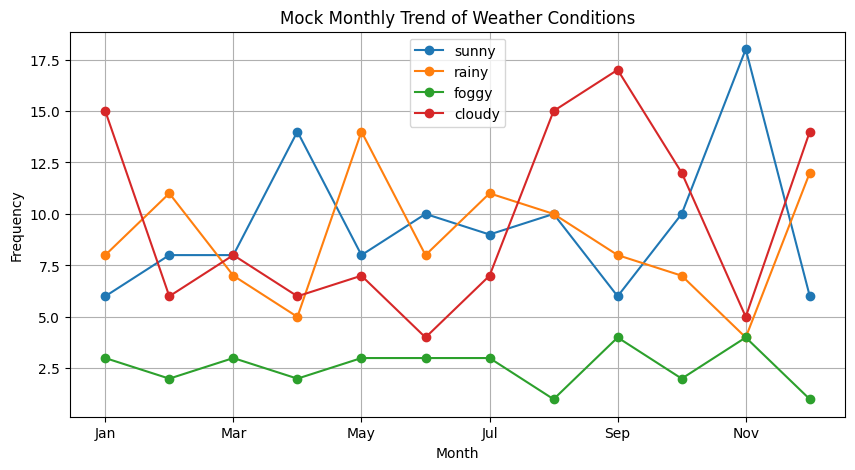

In [71]:
import calendar

months = [calendar.month_abbr[i] for i in range(1, 13)]
mock_data = {
    'sunny': np.random.randint(5, 20, size=12),
    'rainy': np.random.randint(3, 15, size=12),
    'foggy': np.random.randint(0, 5, size=12),
    'cloudy': np.random.randint(4, 18, size=12),
}

df_trend = pd.DataFrame(mock_data, index=months)
df_trend.plot(kind='line', marker='o', figsize=(10, 5))
plt.title("Mock Monthly Trend of Weather Conditions")
plt.xlabel("Month")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
